In [1]:
import numpy as np
import sys
sys.path.append("/yezhirui/evo_probe")
from src.find_contact import *
from src.gmm import *
from src.contact_space import *

## GMM setup

In [7]:
print("=== 初始化数据和模型 ===")

# 1. 获取关键接触点
chemokine_pdb = "1j8i"  # 趋化因子折叠
alternate_pdb = "2jp1"  # 替代折叠
msa_seq = 'EVSDKRT-CVSLTTQRLPVSRIKTYTIT---EGSLRAVIFITKRGLKVCADPQATWVRDVVRSMDRKSNT'
results = calculate_contact_difference_msa_id(chemokine_pdb, alternate_pdb,msa_seq,threshold=10.0,remove_diag=5)
critical_contacts = results['critical_contacts']
print(f"关键接触点数量: {len(critical_contacts)}")

# 2. 加载MJ矩阵
mj_dict = load_mj_matrix("/yezhirui/evo_probe/data/mj_matrix.txt")

# 3. 生成contact embedding

contact_space = ContactSpace(critical_contacts, mj_dict)

# 批量添加节点
path_dir = "/yezhirui/evo_probe/data/sample"
node_configs = [("ANC0", f"{path_dir}/node499_anc0_samples.fasta"),("ANC1", f"{path_dir}/node500_anc1_samples.fasta"),
("ANC2", f"{path_dir}/node501_anc2_samples.fasta"), ("ANC3", f"{path_dir}/node502_anc3_samples.fasta"), ("ANC4", f"{path_dir}/node507_anc4_samples.fasta")]
for node_id, fasta_path in node_configs:
    contact_space.add_node_from_fasta(node_id, fasta_path)

contact_space.build_embeddings()

anc0_contact_embedding = contact_space.get_node_embeddings("ANC0")
anc1_contact_embedding = contact_space.get_node_embeddings("ANC1")
anc2_contact_embedding = contact_space.get_node_embeddings("ANC2")
anc3_contact_embedding = contact_space.get_node_embeddings("ANC3")
anc4_contact_embedding = contact_space.get_node_embeddings("ANC4")

=== 初始化数据和模型 ===
PDB坐标提取完成: 93 个残基 (链 A)
PDB坐标提取完成: 60 个残基 (链 A)
距离矩阵计算完成: 93 x 93
距离矩阵计算完成: 60 x 60
共同残基数量: 60 个 (原始: 93 vs 60)
从PDB提取序列完成: 93 个残基 (链 A)
从PDB提取序列完成: 60 个残基 (链 A)
自动检测到PDB起始偏移量: 3
警告: PDB序列比MSA序列长，有24个PDB残基未映射
PDB到MSA映射完成: 66 个残基 (匹配: 66, 不匹配: 0)
PDB序列长度: 93, MSA序列长度: 70
PDB起始偏移: 3 (PDB第4个残基对应MSA第0个位置)
自动检测到PDB起始偏移量: 3
警告: MSA序列比PDB序列长，MSA位置61(R)无对应PDB残基
PDB到MSA映射完成: 57 个残基 (匹配: 57, 不匹配: 0)
PDB序列长度: 60, MSA序列长度: 70
PDB起始偏移: 3 (PDB第4个残基对应MSA第0个位置)
接触对转换完成: 109 个有效接触对, 2 个跳过
接触对转换完成: 133 个有效接触对, 0 个跳过
接触对转换完成: 1354 个有效接触对, 172 个跳过
关键接触点数量: 242


## GMM projection

=== ANC0 GMM分析 ===
k	BIC分数		对数似然
-----------------------------------
1	-988737.03		596758.72
2	-814869.89		612218.80
3	-805095.37		709725.20
4	-651331.56		735236.95
5	-524336.28		774132.97

最优k值: 1 (BIC = -988737.03)


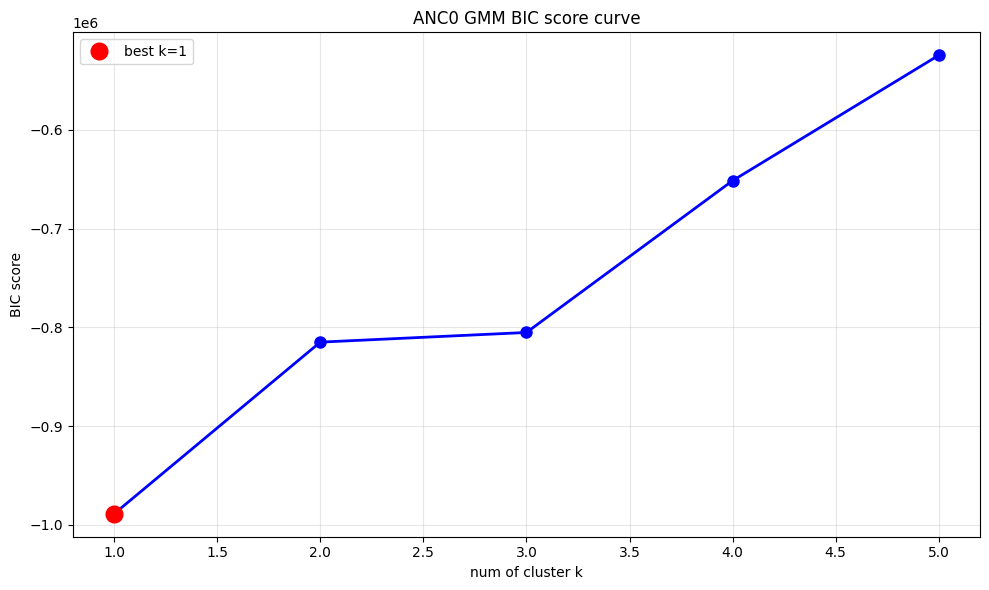

In [8]:
print("=== ANC0 GMM分析 ===")
k_vals, bic_scores,  best_k = gmm_bic_analysis(anc0_contact_embedding, max_k=5, verbose=True)

# 绘制BIC曲线
plot_bic_curve(k_vals, bic_scores, "ANC0 GMM BIC score curve")


=== ANC0 GMM分析 ===
k	BIC分数		对数似然
-----------------------------------
1	-869305.29		537042.85
2	-754394.68		581981.20
3	-706021.56		660188.30
4	-527496.82		673319.58
5	-362026.50		692978.08

最优k值: 1 (BIC = -869305.29)


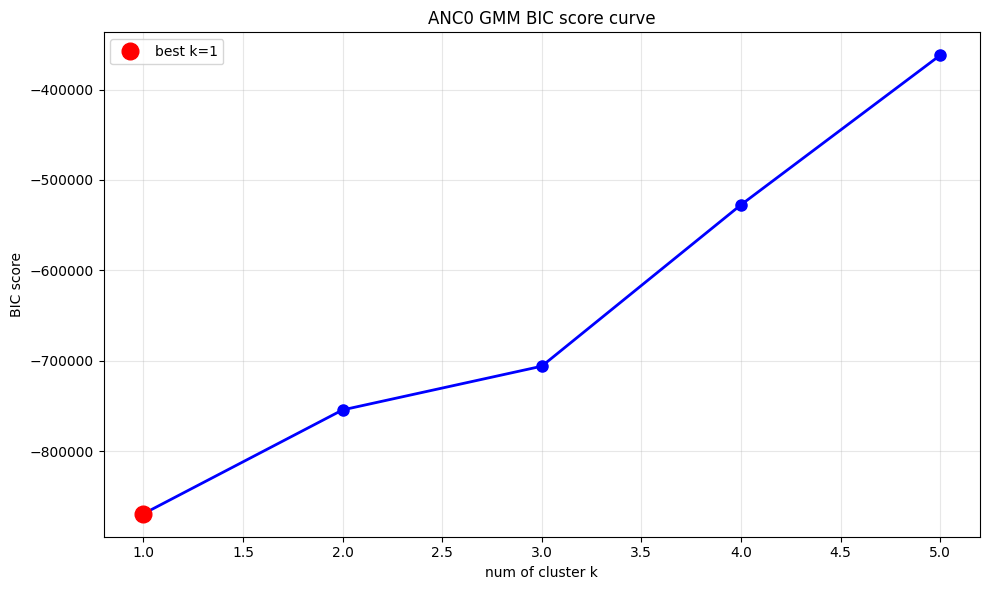

In [ ]:
print("=== ANC1 GMM分析 ===")
k_vals, bic_scores,  best_k = gmm_bic_analysis(anc1_contact_embedding, max_k=5, verbose=True)

# 绘制BIC曲线
plot_bic_curve(k_vals, bic_scores, "ANC1 GMM BIC score curve")


=== ANC2 GMM分析 ===
k	BIC分数		对数似然
-----------------------------------
1	-163446.83		184113.62
2	-68166.14		238866.93
3	18220.13		298067.45
4	114353.18		352394.58
5	302910.23		360509.71

最优k值: 1 (BIC = -163446.83)


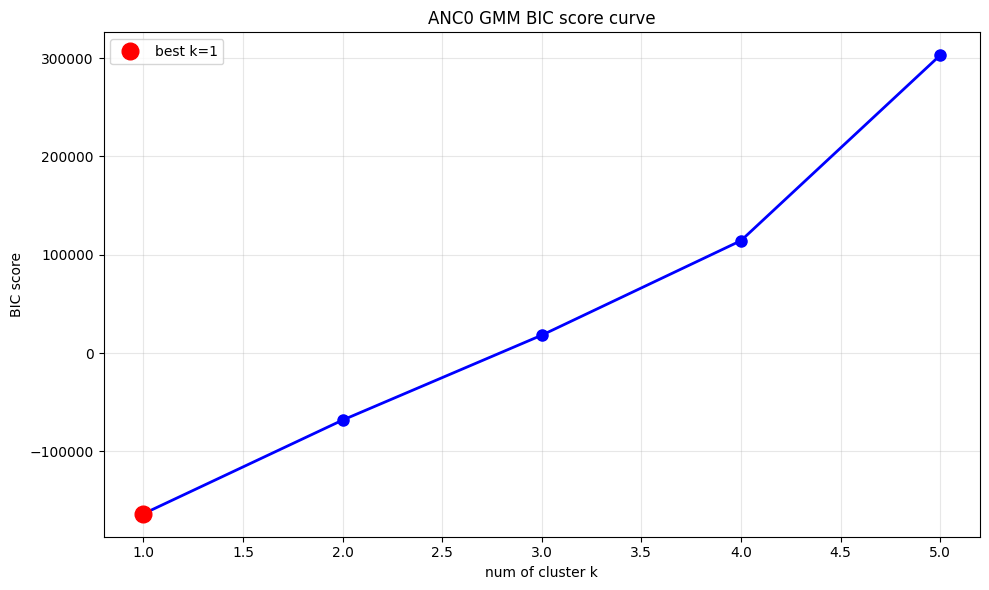

In [ ]:
print("=== ANC2 GMM分析 ===")
k_vals, bic_scores,  best_k = gmm_bic_analysis(anc2_contact_embedding, max_k=5, verbose=True)

# 绘制BIC曲线
plot_bic_curve(k_vals, bic_scores, "ANC2 GMM BIC score curve")


=== ANC3 GMM分析 ===
k	BIC分数		对数似然
-----------------------------------
1	-1390320.68		797550.54
2	-1363605.85		886586.78
3	-1261881.87		938118.45
4	-1085615.20		952378.77
5	-956434.35		990182.00

最优k值: 1 (BIC = -1390320.68)


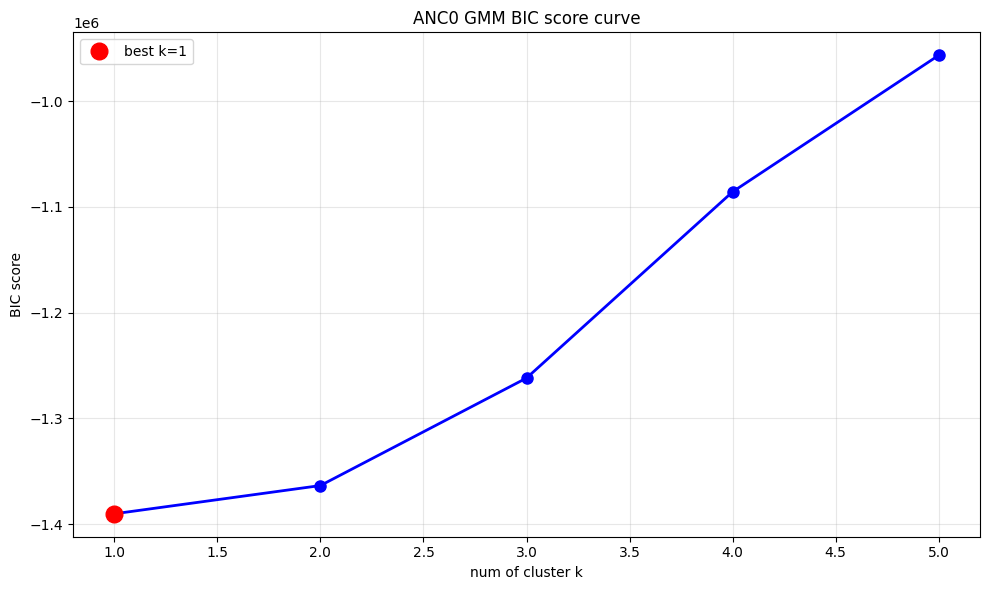

In [ ]:
print("=== ANC3 GMM分析 ===")
k_vals, bic_scores,  best_k = gmm_bic_analysis(anc3_contact_embedding, max_k=5, verbose=True)

# 绘制BIC曲线
plot_bic_curve(k_vals, bic_scores, "ANC3 GMM BIC score curve")


=== ANC4 GMM分析 ===
k	BIC分数		对数似然
-----------------------------------
1	-2286220.39		1245500.40
2	-2142829.64		1276198.68
3	-1986388.45		1300371.74
4	-1803305.31		1311223.83
5	-1624639.42		1324284.54

最优k值: 1 (BIC = -2286220.39)


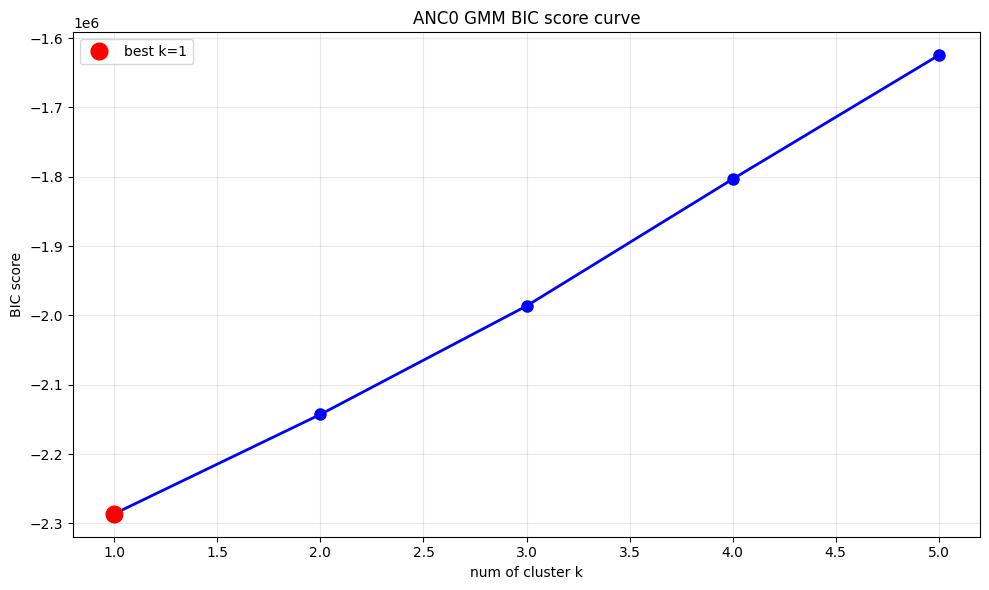

In [ ]:
print("=== ANC4 GMM分析 ===")
k_vals, bic_scores,  best_k = gmm_bic_analysis(anc4_contact_embedding, max_k=5, verbose=True)

# 绘制BIC曲线
plot_bic_curve(k_vals, bic_scores, "ANC4 GMM BIC score curve")



dataset: ANC2
shape: (1000, 242)
=== 基于GMM指导的投影 (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [943  57]
BIC分数: -84921.14

步骤2: 提取聚类中心点...
中心A形状: (242,)
中心B形状: (242,)
投影向量V形状: (242,)
投影向量V模长: 12.8085

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-60.4048, 197.8171]

dataset: ANC3
shape: (1000, 242)
=== 基于GMM指导的投影 (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [292 708]
BIC分数: -1230526.02

步骤2: 提取聚类中心点...
中心A形状: (242,)
中心B形状: (242,)
投影向量V形状: (242,)
投影向量V模长: 5.6091

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-69.3900, 28.6793]

dataset: ANC4
shape: (1000, 242)
=== 基于GMM指导的投影 (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [234 766]
BIC分数: -2037358.08

步骤2: 提取聚类中心点...
中心A形状: (242,)
中心B形状: (242,)
投影向量V形状: (242,)
投影向量V模长: 7.9701

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-81.1620, 34.5062]


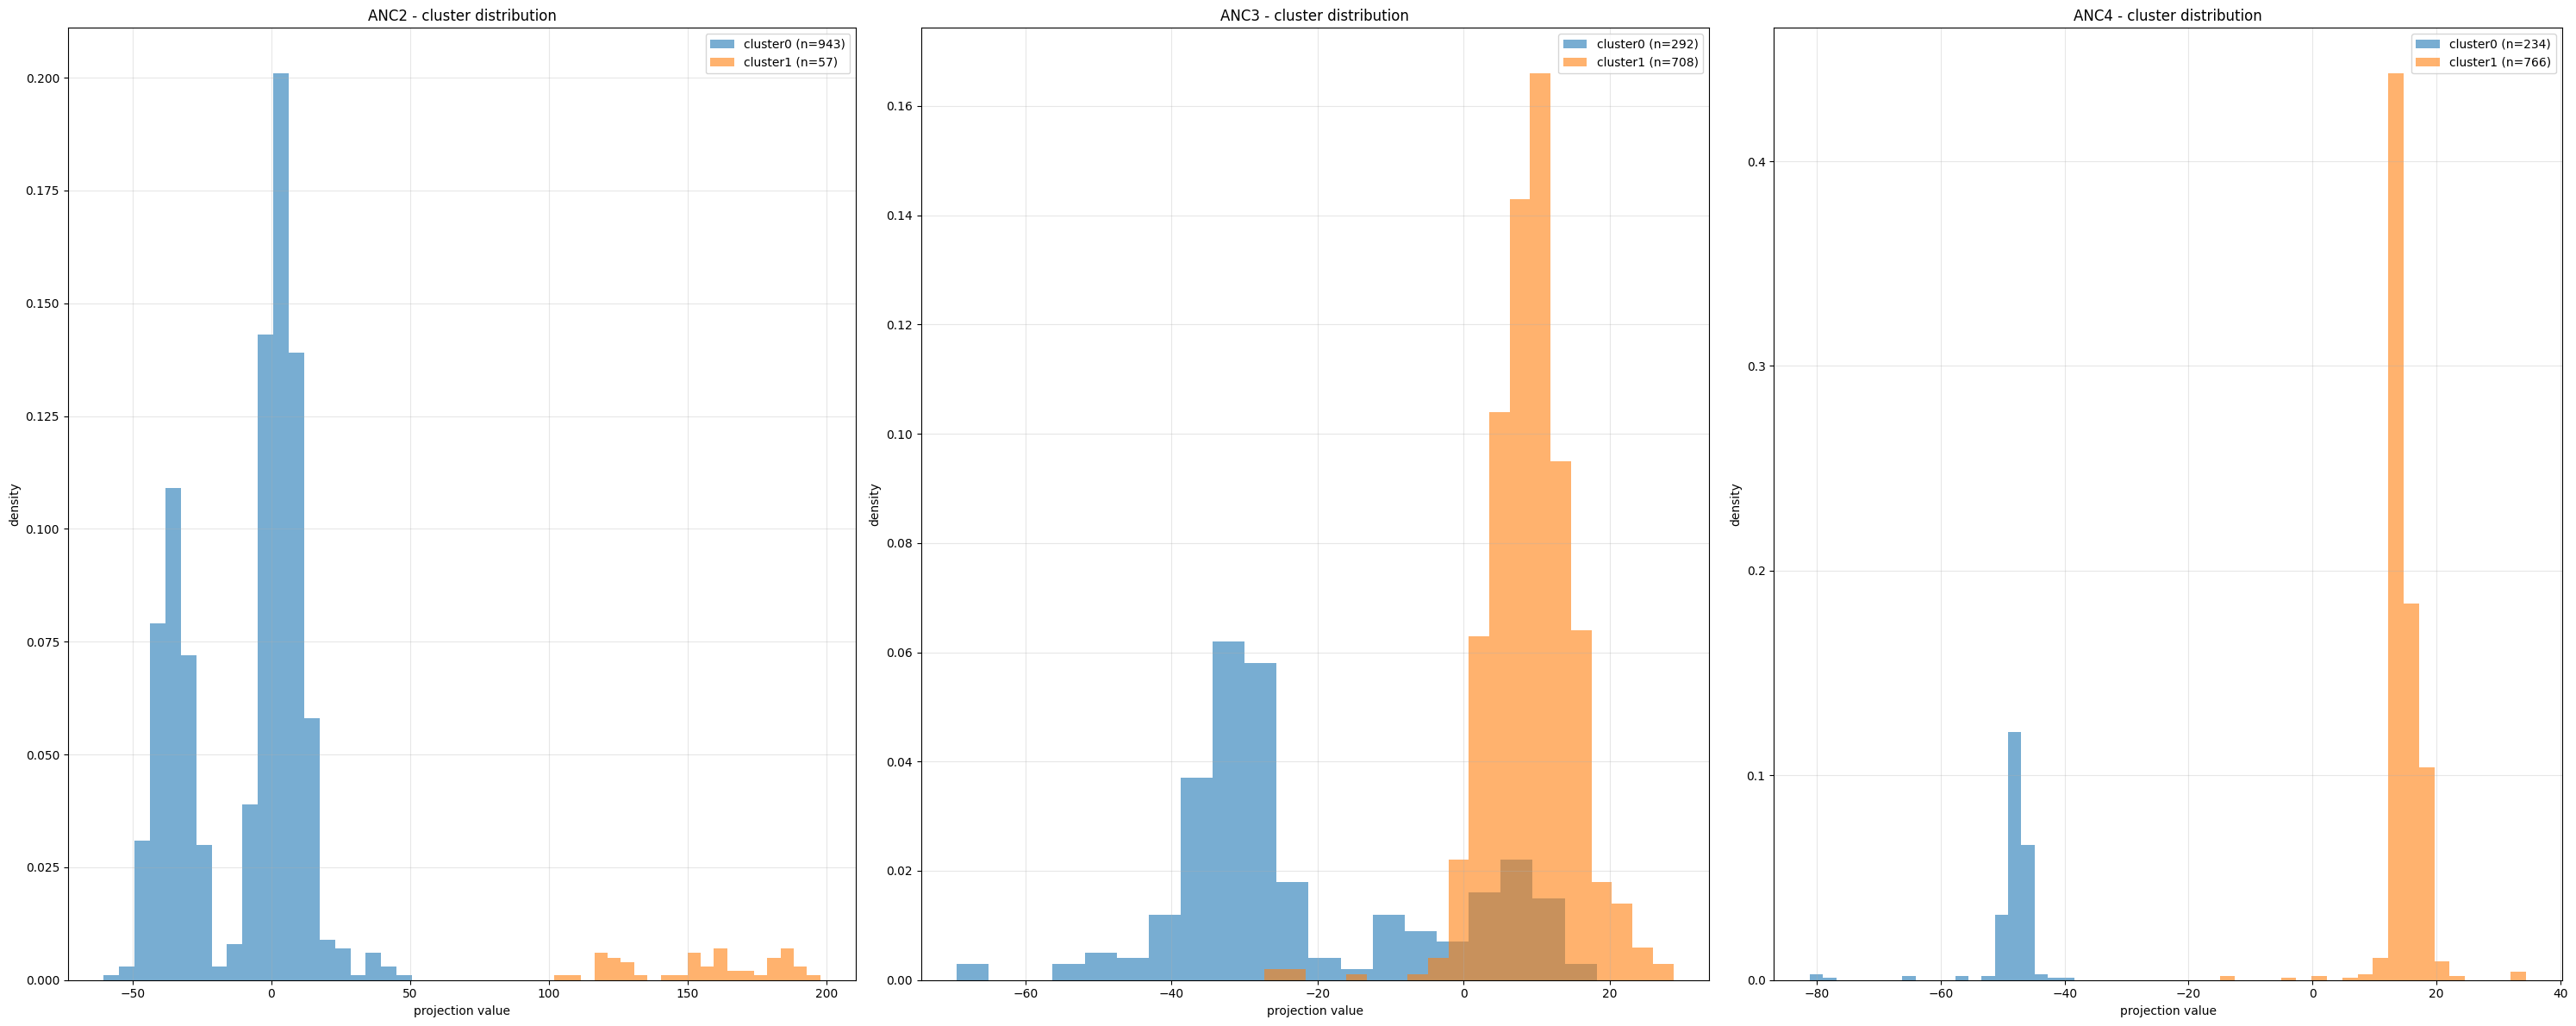

In [6]:

# # 分析anc0数据
# print("=== ANC0 GMM分析 ===")
# k_vals, bic_scores,  best_k = gmm_bic_analysis(anc0_contact_embedding, max_k=5, verbose=True)

# # 绘制BIC曲线
# plot_bic_curve(k_vals, bic_scores, "ANC0 GMM BIC score curve")


# # 使用最优k值进行聚类
# gmm_model, gmm_labels, gmm_probs = gmm_cluster_analysis(anc0_contact_embedding, 2)
# print(f"GMM聚类结果: {len(np.unique(gmm_labels))}个聚类")
# print(f"各聚类大小: {np.bincount(gmm_labels)}")


datasets = {
    'ANC2': anc2_contact_embedding,
    'ANC3': anc3_contact_embedding,
    'ANC4': anc4_contact_embedding
}

all_results = compare_gmm_guided_projections(
    datasets,
    k=2,
    figsize=(30, 12)
)

# anc0_results = all_results['ANC0']
# anc1_results = all_results['ANC1']
anc2_results = all_results['ANC2']
anc3_results = all_results['ANC3']
anc4_results = all_results['ANC4']

## GMM soft cluster label

定量描述序列的构象倾向，识别过渡态。

In [30]:
anc0_p2=anc0_results['probabilities'][:,1]
anc1_p2=anc1_results['probabilities'][:,1]
anc2_p2=anc2_results['probabilities'][:,1]
anc3_p2=anc3_results['probabilities'][:,1]
anc4_p2=anc4_results['probabilities'][:,1]

density plot

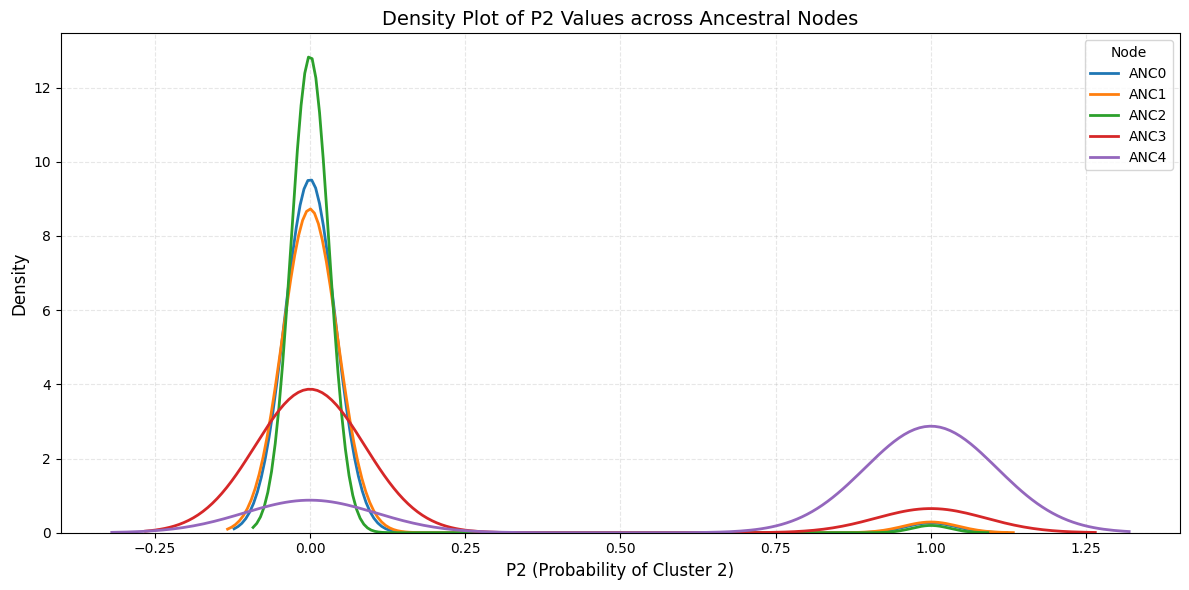

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# 准备数据
data_dict = {
    'ANC0': anc0_p2,
    'ANC1': anc1_p2,
    'ANC2': anc2_p2,
    'ANC3': anc3_p2,
    'ANC4': anc4_p2
}

# 创建密度图
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for (name, values), color in zip(data_dict.items(), colors):
    sns.kdeplot(values, label=name, color=color, linewidth=2, ax=ax)

ax.set_xlabel('P2 (Probability of Cluster 2)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Density Plot of P2 Values across Ancestral Nodes', fontsize=14)
ax.legend(title='Node', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [32]:
# 检查是否有越界值（<0 或 >1）
print(any((arr < 0).any() or (arr > 1).any() for arr in [anc0_p2, anc1_p2, anc2_p2, anc3_p2, anc4_p2]))

False


## 协方差分析

揭示能量项之间的约束、协同和补偿关系（上位效应）

对角线元素：某个维度上的方差大小，反映了该残基对相互作用能在**这个聚类内部**的可变性。

非对角线元素：如果两个维度（例如，残基对A的能量和残基对B的能量）之间的协方差不为零，说明它们的能量值是**相关的**。

- **正协方差** ： 为了维持在这个聚类中，A和B的能量倾向于“同向变化”。这可能代表了**协同效应（synergy）**，例如它们同属于一个大的疏水核心网络
- **负协方差** ： 说明A和B的能量倾向于“反向变化”。如果A的相互作用变差（能量升高），B的相互作用就必须变好（能量降低）来**补偿**。这直接揭示了**补偿性突变（compensatory mutations）**和能量网络中的**权衡（trade-offs）**，是揭示上位效应（epistasis）的有力证据

In [33]:
anc0_cov = anc0_results['covariances']
anc1_cov = anc1_results['covariances']
anc2_cov = anc2_results['covariances']
anc3_cov = anc3_results['covariances']
anc4_cov = anc4_results['covariances']



In [34]:
print(anc0_cov.shape)

(2, 244, 244)


对角线元素

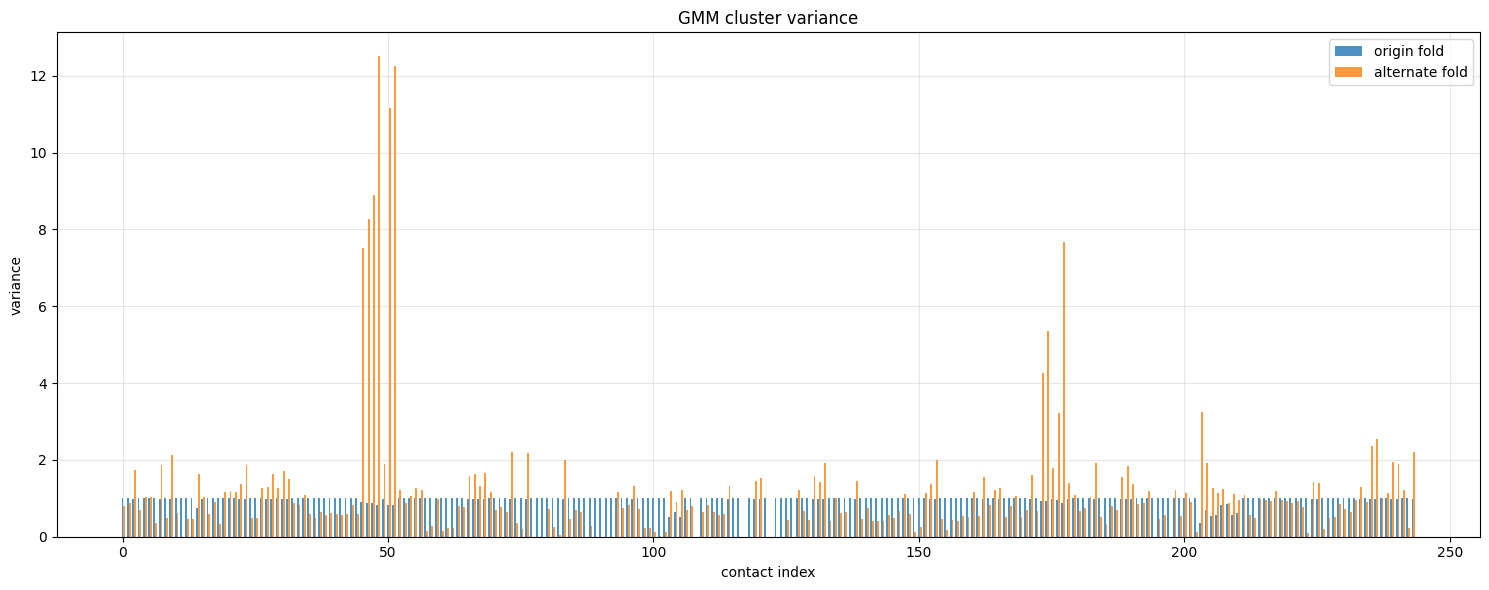

In [35]:
def plot_gmm_variance_comparison(covariances: np.ndarray, 
                               labels: List[str] = ['cluster1', 'cluster2']) -> np.ndarray:
    """
    绘制GMM协方差对角线元素比较 
    """
    import matplotlib.pyplot as plt
    
    # 提取对角线元素
    variances = np.array([np.diag(cov) for cov in covariances])
    
    # 绘图
    x = np.arange(variances.shape[1])
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(15, 6))
    
    for i, (var, label) in enumerate(zip(variances, labels)):
        ax.bar(x + i*width, var, width, label=label, alpha=0.8)
    
    ax.set_xlabel('contact index')
    ax.set_ylabel('variance')
    ax.set_title('GMM cluster variance')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return variances

variances = plot_gmm_variance_comparison(anc2_cov, ['origin fold', 'alternate fold'])

**差异/比率棒棒糖图 (Difference/Ratio Lollipop Plot)**

- log2(Ratio)>0 (棒棒糖在右侧): 说明在聚类2中方差更大，即从状态1演化到状态2，这个维度的约束变宽松了。值越大，说明宽松的程度越高。
- log2(Ratio)<0 (棒棒糖在左侧): 说明在聚类2中方差更小，约束变严格了。绝对值越大，说明约束收紧得越厉害。
- log2(Ratio)≈0: 说明约束基本没有变化。

这个图能清晰地展示每个能量维度约束变化的方向和强度。

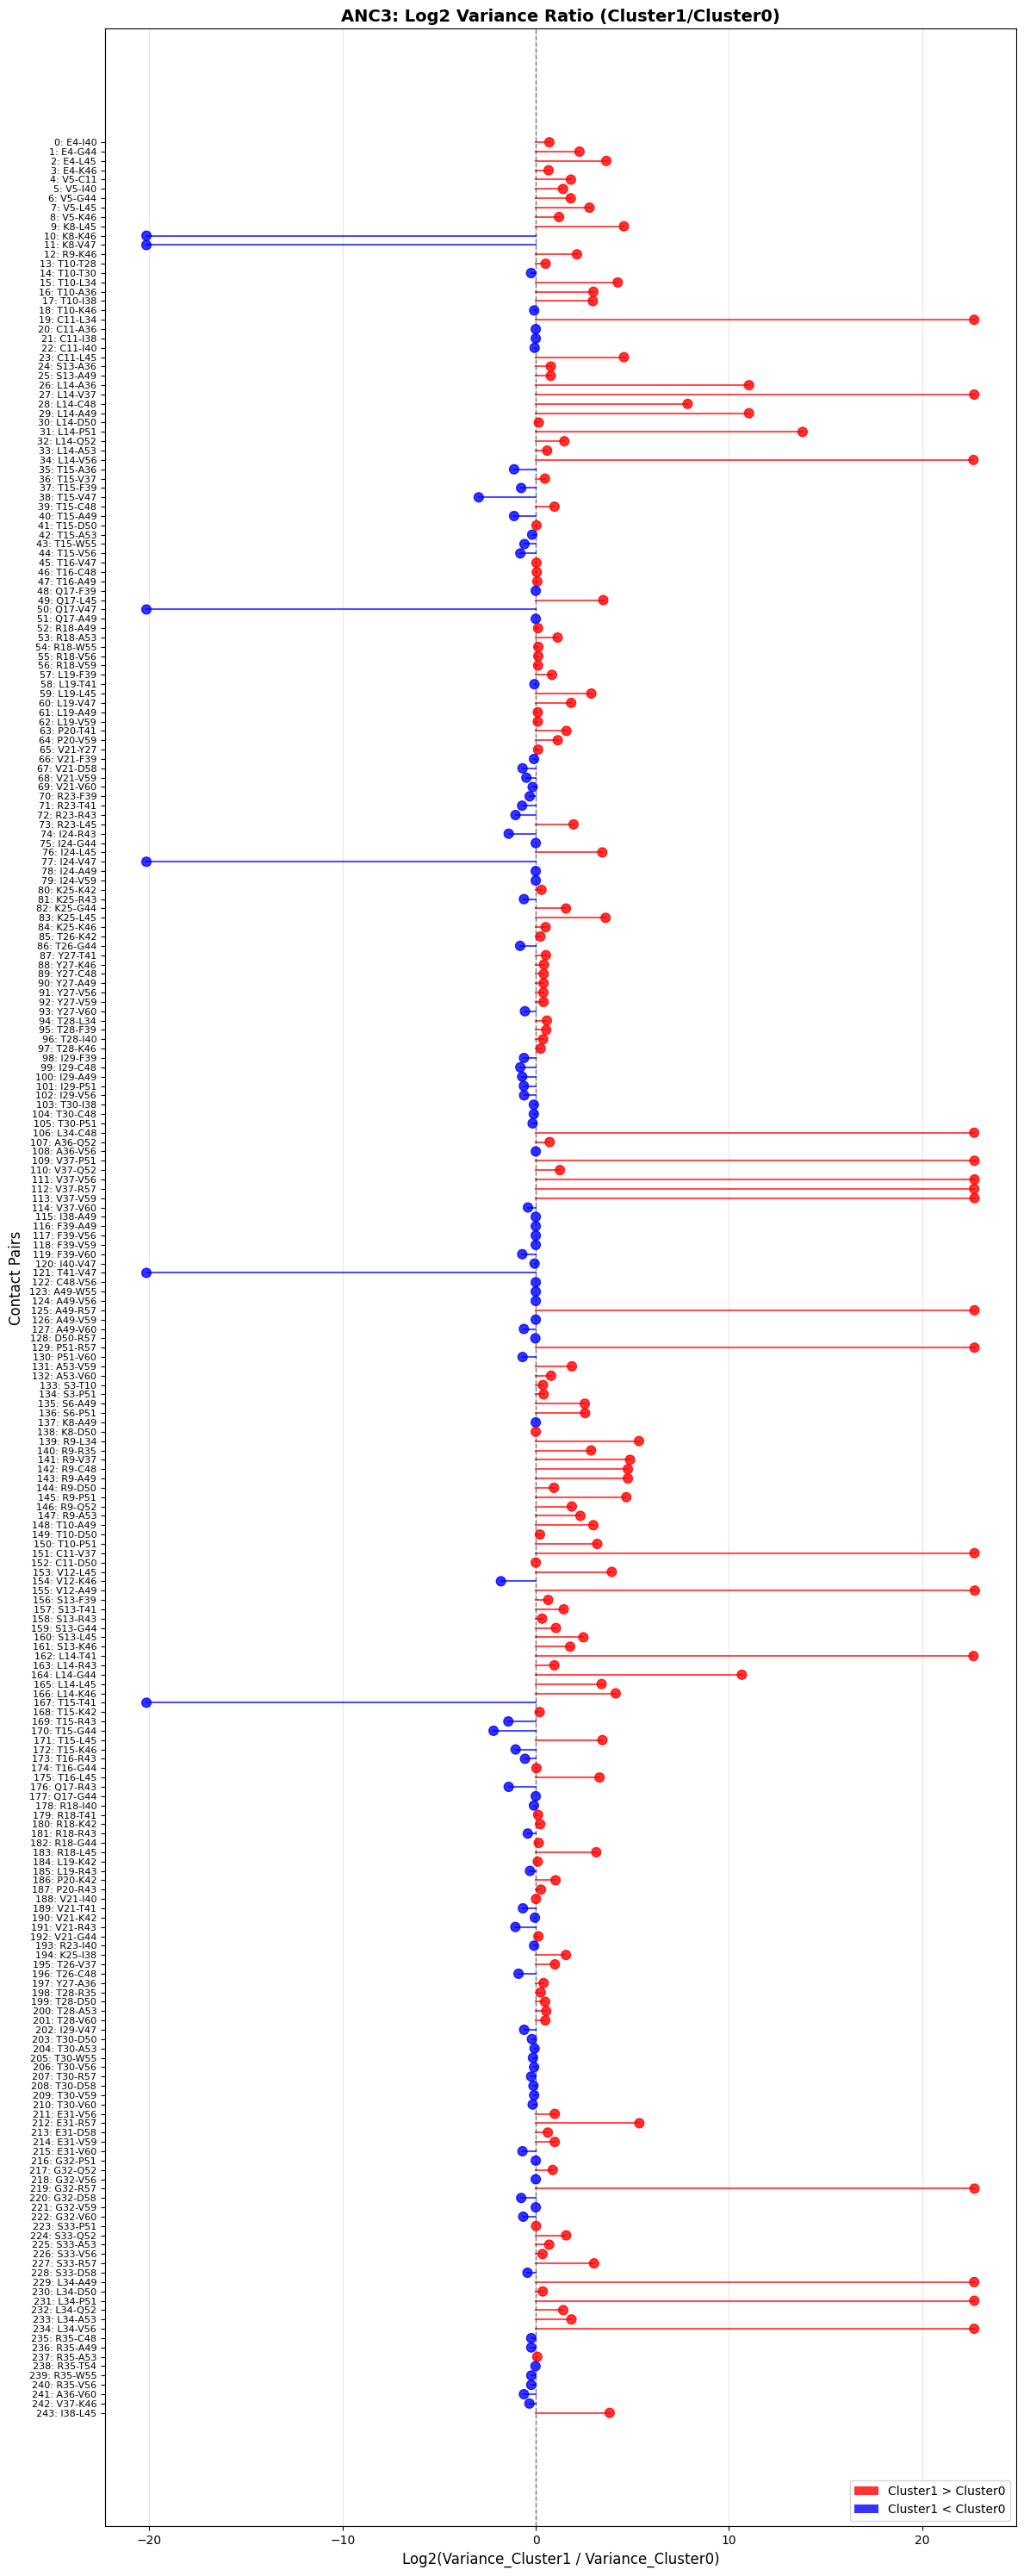


=== 对数方差比统计 ===
最大值: 22.7265
最小值: -20.1555
平均值: 1.8932
标准差: 6.8644
Cluster0 > Cluster1 的数量: 147
Cluster0 < Cluster1 的数量: 76


In [62]:
def plot_variance_ratio_lollipop(covariances, critical_contacts, results, visualize=True,
                                figsize=(12, 20), top_n=None, 
                                title="Log2 Variance Ratio (Cluster0/Cluster1)"):
    """
    绘制对数方差比的棒棒糖图
    
    Args:
        covariances: 协方差矩阵 shape (2, 244, 244)
        critical_contacts: 关键接触点列表
        results: contact difference分析结果
        figsize: 图片大小
        top_n: 只显示前n个最大绝对值的比率，None表示显示全部
        title: 图片标题
    """
    import matplotlib.pyplot as plt
    
    # 提取两个cluster的方差（对角线元素）
    var_cluster0 = np.diag(covariances[0])
    var_cluster1 = np.diag(covariances[1])
    
    # 计算对数方差比 log2(Variance_cluster1 / Variance_cluster0)
    # 添加小的epsilon避免除零
    epsilon = 1e-10
    log_ratio = np.log2((var_cluster1 + epsilon) / (var_cluster0 + epsilon))
    
    # 获取contact信息
    contact_labels = []
    for i in range(len(critical_contacts)):
        contact_info = get_contact_info(critical_contacts, i, results['alternate_residue_types'])
        contact_labels.append(f"{i}: {contact_info}")
    
    # 如果指定了top_n，只显示绝对值最大的前n个
    if top_n is not None:
        top_indices = np.argsort(np.abs(log_ratio))[-top_n:][::-1]
        log_ratio_plot = log_ratio[top_indices]
        contact_labels_plot = [contact_labels[i] for i in top_indices]
        y_positions = range(len(log_ratio_plot))
    else:
        log_ratio_plot = log_ratio
        contact_labels_plot = contact_labels
        y_positions = range(len(log_ratio_plot))

    if visualize:
        
        # 创建图形
        fig, ax = plt.subplots(figsize=figsize)
        
        # 绘制棒棒糖图
        colors = ['red' if x > 0 else 'blue' for x in log_ratio_plot]
        
        # 绘制棒子（水平线）
        for i, (y, x) in enumerate(zip(y_positions, log_ratio_plot)):
            ax.plot([0, x], [y, y], color=colors[i], linewidth=1.5, alpha=0.7)
        
        # 绘制糖果（圆点）
        ax.scatter(log_ratio_plot, y_positions, c=colors, s=60, alpha=0.8, zorder=5)
        
        # 添加中心线 x=0
        ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        # 设置Y轴标签
        ax.set_yticks(y_positions)
        ax.set_yticklabels(contact_labels_plot, fontsize=8)
        
        # 设置轴标签和标题
        ax.set_xlabel('Log2(Variance_Cluster1 / Variance_Cluster0)', fontsize=12)
        ax.set_ylabel('Contact Pairs', fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        # 添加网格
        ax.grid(True, alpha=0.3, axis='x')
        
        # 添加图例
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='red', alpha=0.8, label='Cluster1 > Cluster0'),
            Patch(facecolor='blue', alpha=0.8, label='Cluster1 < Cluster0')
        ]
        ax.legend(handles=legend_elements, loc='lower right')
        
        # 反转Y轴，使第一个contact在顶部
        ax.invert_yaxis()
        
        # 调整布局
        plt.tight_layout()
        plt.show()
        
    # 返回统计信息
    stats = {
        'log_ratios': log_ratio,
        'max_ratio': np.max(log_ratio),
        'min_ratio': np.min(log_ratio),
        'mean_ratio': np.mean(log_ratio),
        'std_ratio': np.std(log_ratio),
        'positive_count': np.sum(log_ratio > 0),
        'negative_count': np.sum(log_ratio < 0)
    }
    
    print(f"\n=== 对数方差比统计 ===")
    print(f"最大值: {stats['max_ratio']:.4f}")
    print(f"最小值: {stats['min_ratio']:.4f}")
    print(f"平均值: {stats['mean_ratio']:.4f}")
    print(f"标准差: {stats['std_ratio']:.4f}")
    print(f"Cluster0 > Cluster1 的数量: {stats['positive_count']}")
    print(f"Cluster0 < Cluster1 的数量: {stats['negative_count']}")
    
    return stats

# 使用示例：
# 显示所有contact的棒棒糖图
variance_stats = plot_variance_ratio_lollipop(
    anc3_cov, 
    critical_contacts, 
    results,
    figsize=(12, 30),  # 高一点以容纳所有244个contact
    title="ANC3: Log2 Variance Ratio (Cluster1/Cluster0)"
)


In [54]:
def analyze_extreme_variance_ratios_with_contact_type(covariances, critical_contacts, results, 
                                                    top_red_n=15, top_blue_n=6):
    """
    分析方差比的极值点对应的接触对，并标识是lost还是gain
    
    Args:
        covariances: 协方差矩阵 shape (2, 244, 244)
        critical_contacts: 关键接触点列表
        results: contact difference分析结果
        top_red_n: 要提取的最大红色点数量
        top_blue_n: 要提取的最小蓝色点数量
    
    Returns:
        dict: 包含极值点信息的字典
    """
    
    # 提取两个cluster的方差（对角线元素）
    var_cluster0 = np.diag(covariances[0])
    var_cluster1 = np.diag(covariances[1])
    
    # 计算对数方差比 log2(Variance_cluster1 / Variance_cluster0)
    epsilon = 1e-10
    log_ratio = np.log2((var_cluster1 + epsilon) / (var_cluster0 + epsilon))
    
    # 获取lost和gain的接触对
    lost_contacts = results['lost_contacts']
    new_contacts = results['new_contacts']  # gain contacts
    
    def get_contact_type(contact_pair):
        """判断接触对是lost还是gain"""
        if contact_pair in lost_contacts:
            return "LOST"
        elif contact_pair in new_contacts:
            return "GAIN"
        else:
            return "UNKNOWN"
    
    # 分离正值（红色点）和负值（蓝色点）
    positive_indices = np.where(log_ratio > 0)[0]
    negative_indices = np.where(log_ratio < 0)[0]
    
    positive_ratios = log_ratio[positive_indices]
    negative_ratios = log_ratio[negative_indices]
    
    # 找到最大的红色点（正值最大）
    if len(positive_ratios) >= top_red_n:
        top_positive_idx = np.argsort(positive_ratios)[-top_red_n:][::-1]  # 降序
        top_red_indices = positive_indices[top_positive_idx]
        top_red_ratios = positive_ratios[top_positive_idx]
    else:
        top_red_indices = positive_indices[np.argsort(positive_ratios)[::-1]]
        top_red_ratios = positive_ratios[np.argsort(positive_ratios)[::-1]]
    
    # 找到最小的蓝色点（负值最小）
    if len(negative_ratios) >= top_blue_n:
        top_negative_idx = np.argsort(negative_ratios)[:top_blue_n]  # 升序（最小的）
        top_blue_indices = negative_indices[top_negative_idx]
        top_blue_ratios = negative_ratios[top_negative_idx]
    else:
        top_blue_indices = negative_indices[np.argsort(negative_ratios)]
        top_blue_ratios = negative_ratios[np.argsort(negative_ratios)]
    
    print(f"=== X值最大的{len(top_red_indices)}个红色点 (Cluster1 >> Cluster0) ===")
    top_red_contacts = []
    for i, (idx, ratio) in enumerate(zip(top_red_indices, top_red_ratios)):
        contact_info = get_contact_info(critical_contacts, idx, results['alternate_residue_types'])
        contact_pair = critical_contacts[idx]
        contact_type = get_contact_type(contact_pair)
        
        top_red_contacts.append({
            'rank': i + 1,
            'index': idx,
            'log_ratio': ratio,
            'contact_info': contact_info,
            'contact_pair': contact_pair,
            'contact_type': contact_type,
            'cluster0_var': var_cluster0[idx],
            'cluster1_var': var_cluster1[idx]
        })
        print(f"{i+1:2d}. Index {idx:3d}: {contact_info:15s} | {contact_type:7s} | Log2_ratio = {ratio:6.3f} | "
              f"Var0 = {var_cluster0[idx]:.2e} | Var1 = {var_cluster1[idx]:.2e}")
    
    print(f"\n=== X值最小的{len(top_blue_indices)}个蓝色点 (Cluster0 >> Cluster1) ===")
    top_blue_contacts = []
    for i, (idx, ratio) in enumerate(zip(top_blue_indices, top_blue_ratios)):
        contact_info = get_contact_info(critical_contacts, idx, results['alternate_residue_types'])
        contact_pair = critical_contacts[idx]
        contact_type = get_contact_type(contact_pair)
        
        top_blue_contacts.append({
            'rank': i + 1,
            'index': idx,
            'log_ratio': ratio,
            'contact_info': contact_info,
            'contact_pair': contact_pair,
            'contact_type': contact_type,
            'cluster0_var': var_cluster0[idx],
            'cluster1_var': var_cluster1[idx]
        })
        print(f"{i+1:2d}. Index {idx:3d}: {contact_info:15s} | {contact_type:7s} | Log2_ratio = {ratio:6.3f} | "
              f"Var0 = {var_cluster0[idx]:.2e} | Var1 = {var_cluster1[idx]:.2e}")
    
    # 统计contact类型分布
    red_lost_count = sum(1 for item in top_red_contacts if item['contact_type'] == 'LOST')
    red_gain_count = sum(1 for item in top_red_contacts if item['contact_type'] == 'GAIN')
    blue_lost_count = sum(1 for item in top_blue_contacts if item['contact_type'] == 'LOST')
    blue_gain_count = sum(1 for item in top_blue_contacts if item['contact_type'] == 'GAIN')
    
    print(f"\n=== Contact类型统计 ===")
    print(f"红色点 (Cluster1 >> Cluster0): LOST={red_lost_count}, GAIN={red_gain_count}")
    print(f"蓝色点 (Cluster0 >> Cluster1): LOST={blue_lost_count}, GAIN={blue_gain_count}")

    print(f"top_blue_indices: {top_blue_indices}")
    print(f"top_red_indices: {top_red_indices}")
    
    return {
        'top_red_contacts': top_red_contacts,
        'top_blue_contacts': top_blue_contacts,
        'all_log_ratios': log_ratio,
        'contact_type_stats': {
            'red_lost_count': red_lost_count,
            'red_gain_count': red_gain_count,
            'blue_lost_count': blue_lost_count,
            'blue_gain_count': blue_gain_count
        },
        'summary': {
            'total_positive': len(positive_indices),
            'total_negative': len(negative_indices),
            'max_positive': np.max(log_ratio) if len(positive_indices) > 0 else None,
            'min_negative': np.min(log_ratio) if len(negative_indices) > 0 else None
        }
    }

extreme_analysis_with_type = analyze_extreme_variance_ratios_with_contact_type(
    anc3_cov, 
    critical_contacts, 
    results,
    top_red_n=15,  # 最大的15个红色点
    top_blue_n=7   # 最小的6个蓝色点
)

# 如果你想要按类型分组的接触对
red_lost_contacts = [item['contact_info'] for item in extreme_analysis_with_type['top_red_contacts'] 
                     if item['contact_type'] == 'LOST']
red_gain_contacts = [item['contact_info'] for item in extreme_analysis_with_type['top_red_contacts'] 
                     if item['contact_type'] == 'GAIN']

blue_lost_contacts = [item['contact_info'] for item in extreme_analysis_with_type['top_blue_contacts'] 
                      if item['contact_type'] == 'LOST']
blue_gain_contacts = [item['contact_info'] for item in extreme_analysis_with_type['top_blue_contacts'] 
                      if item['contact_type'] == 'GAIN']

print(f"\n=== 按类型分组的接触对 ===")
print(f"红色点中的LOST接触: {red_lost_contacts}")
print(f"红色点中的GAIN接触: {red_gain_contacts}")
print(f"蓝色点中的LOST接触: {blue_lost_contacts}")
print(f"蓝色点中的GAIN接触: {blue_gain_contacts}")



=== X值最大的15个红色点 (Cluster1 >> Cluster0) ===
 1. Index 155: V12-A49         | GAIN    | Log2_ratio = 22.726 | Var0 = 1.00e-06 | Var1 = 6.94e+00
 2. Index 111: V37-V56         | LOST    | Log2_ratio = 22.710 | Var0 = 1.00e-06 | Var1 = 6.86e+00
 3. Index 129: P51-R57         | LOST    | Log2_ratio = 22.710 | Var0 = 1.00e-06 | Var1 = 6.86e+00
 4. Index 151: C11-V37         | GAIN    | Log2_ratio = 22.710 | Var0 = 1.00e-06 | Var1 = 6.86e+00
 5. Index 125: A49-R57         | LOST    | Log2_ratio = 22.710 | Var0 = 1.00e-06 | Var1 = 6.86e+00
 6. Index 113: V37-V59         | LOST    | Log2_ratio = 22.710 | Var0 = 1.00e-06 | Var1 = 6.86e+00
 7. Index 219: G32-R57         | GAIN    | Log2_ratio = 22.710 | Var0 = 1.00e-06 | Var1 = 6.86e+00
 8. Index 109: V37-P51         | LOST    | Log2_ratio = 22.710 | Var0 = 1.00e-06 | Var1 = 6.86e+00
 9. Index 231: L34-P51         | GAIN    | Log2_ratio = 22.698 | Var0 = 1.00e-06 | Var1 = 6.81e+00
10. Index  27: L14-V37         | LOST    | Log2_ratio = 22.697 | V

In [38]:
extreme_analysis_with_type = analyze_extreme_variance_ratios_with_contact_type(
    anc4_cov, 
    critical_contacts, 
    results,
    top_red_n=12,  
    top_blue_n=8
)

# 如果你想要按类型分组的接触对
red_lost_contacts = [item['contact_info'] for item in extreme_analysis_with_type['top_red_contacts'] 
                     if item['contact_type'] == 'LOST']
red_gain_contacts = [item['contact_info'] for item in extreme_analysis_with_type['top_red_contacts'] 
                     if item['contact_type'] == 'GAIN']

blue_lost_contacts = [item['contact_info'] for item in extreme_analysis_with_type['top_blue_contacts'] 
                      if item['contact_type'] == 'LOST']
blue_gain_contacts = [item['contact_info'] for item in extreme_analysis_with_type['top_blue_contacts'] 
                      if item['contact_type'] == 'GAIN']

print(f"\n=== 按类型分组的接触对 ===")
print(f"红色点中的LOST接触: {red_lost_contacts}")
print(f"红色点中的GAIN接触: {red_gain_contacts}")
print(f"蓝色点中的LOST接触: {blue_lost_contacts}")
print(f"蓝色点中的GAIN接触: {blue_gain_contacts}")

=== X值最大的12个红色点 (Cluster1 >> Cluster0) ===
 1. Index 174: T16-G44         | GAIN    | Log2_ratio = 20.316 | Var0 = 1.00e-06 | Var1 = 1.31e+00
 2. Index  47: T16-A49         | LOST    | Log2_ratio = 20.316 | Var0 = 1.00e-06 | Var1 = 1.31e+00
 3. Index  46: T16-C48         | LOST    | Log2_ratio = 20.316 | Var0 = 1.00e-06 | Var1 = 1.31e+00
 4. Index  88: Y27-K46         | LOST    | Log2_ratio = 20.314 | Var0 = 1.00e-06 | Var1 = 1.30e+00
 5. Index  89: Y27-C48         | LOST    | Log2_ratio = 20.314 | Var0 = 1.00e-06 | Var1 = 1.30e+00
 6. Index 197: Y27-A36         | GAIN    | Log2_ratio = 20.314 | Var0 = 1.00e-06 | Var1 = 1.30e+00
 7. Index  92: Y27-V59         | LOST    | Log2_ratio = 20.314 | Var0 = 1.00e-06 | Var1 = 1.30e+00
 8. Index  90: Y27-A49         | LOST    | Log2_ratio = 20.314 | Var0 = 1.00e-06 | Var1 = 1.30e+00
 9. Index  65: V21-Y27         | LOST    | Log2_ratio = 20.314 | Var0 = 1.00e-06 | Var1 = 1.30e+00
10. Index  91: Y27-V56         | LOST    | Log2_ratio = 20.314 | V

配对散点图 (Pairwise Scatter Plot)

X轴: 每个维度在 Anc2-cluster0 中的方差。

Y轴: 每个维度在 Anc3-cluster0 中的方差。

绘制y=x对角线。

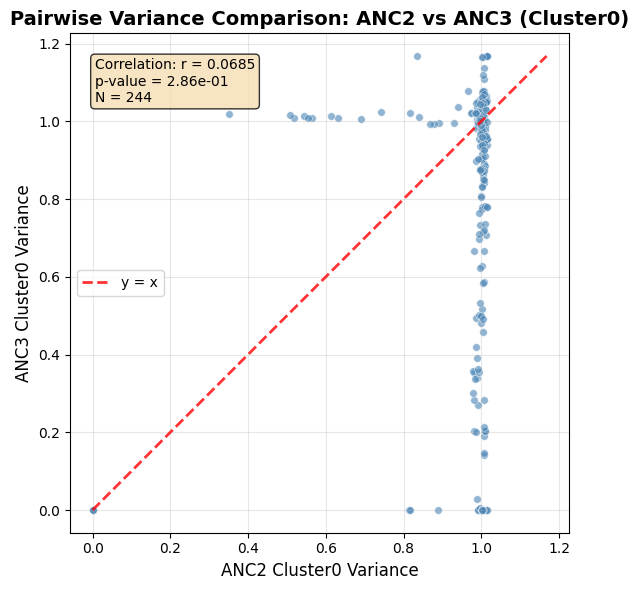


=== 统计结果 ===
相关系数: 0.0685
p值: 2.86e-01
ANC2 方差均值: 0.965491
ANC3 方差均值: 0.718755


In [39]:
def plot_pairwise_variance_scatter(cov1, cov2, cluster_id, 
                                 name1="ANC2", name2="ANC3",
                                 figsize=(10, 10), alpha=0.6):
    """
    绘制两个数据集在指定cluster中的方差配对散点图
    
    Args:
        cov1: 第一个数据集的协方差矩阵 (2, 244, 244)
        cov2: 第二个数据集的协方差矩阵 (2, 244, 244)
        cluster_id: 要比较的cluster编号 (0 or 1)
        name1, name2: 数据集名称
        figsize: 图片大小
        alpha: 点的透明度
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    # 提取指定cluster的方差（对角线元素）
    var1 = np.diag(cov1[cluster_id])
    var2 = np.diag(cov2[cluster_id])
    
    # 创建图形
    fig, ax = plt.subplots(figsize=figsize)
    
    # 绘制散点图
    scatter = ax.scatter(var1, var2, alpha=alpha, s=30, c='steelblue', edgecolors='white', linewidth=0.5)
    
    # 绘制y=x对角线
    min_val = min(np.min(var1), np.min(var2))
    max_val = max(np.max(var1), np.max(var2))
    diagonal_line = np.linspace(min_val, max_val, 100)
    ax.plot(diagonal_line, diagonal_line, 'r--', linewidth=2, alpha=0.8, label='y = x')
    
    # 计算相关系数
    correlation, p_value = stats.pearsonr(var1, var2)
    

    
    # 设置轴标签和标题
    ax.set_xlabel(f'{name1} Cluster{cluster_id} Variance', fontsize=12)
    ax.set_ylabel(f'{name2} Cluster{cluster_id} Variance', fontsize=12)
    ax.set_title(f'Pairwise Variance Comparison: {name1} vs {name2} (Cluster{cluster_id})', 
                fontsize=14, fontweight='bold')
    
    # 添加统计信息文本框
    stats_text = f'Correlation: r = {correlation:.4f}\np-value = {p_value:.2e}\nN = {len(var1)}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 添加网格和图例
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 设置相等的轴比例
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.show()
    
    # 返回统计信息
    return {
        'correlation': correlation,
        'p_value': p_value,
        'var1_mean': np.mean(var1),
        'var2_mean': np.mean(var2),
        'var1_std': np.std(var1),
        'var2_std': np.std(var2),

    }

# 使用示例：绘制ANC2-cluster0 vs ANC3-cluster0的方差散点图
stats_result = plot_pairwise_variance_scatter(
    anc2_cov, 
    anc3_cov, 
    cluster_id=0,
    name1="ANC2", 
    name2="ANC3",
    figsize=(6, 6)
)

print(f"\n=== 统计结果 ===")
print(f"相关系数: {stats_result['correlation']:.4f}")
print(f"p值: {stats_result['p_value']:.2e}")
print(f"ANC2 方差均值: {stats_result['var1_mean']:.6f}")
print(f"ANC3 方差均值: {stats_result['var2_mean']:.6f}")


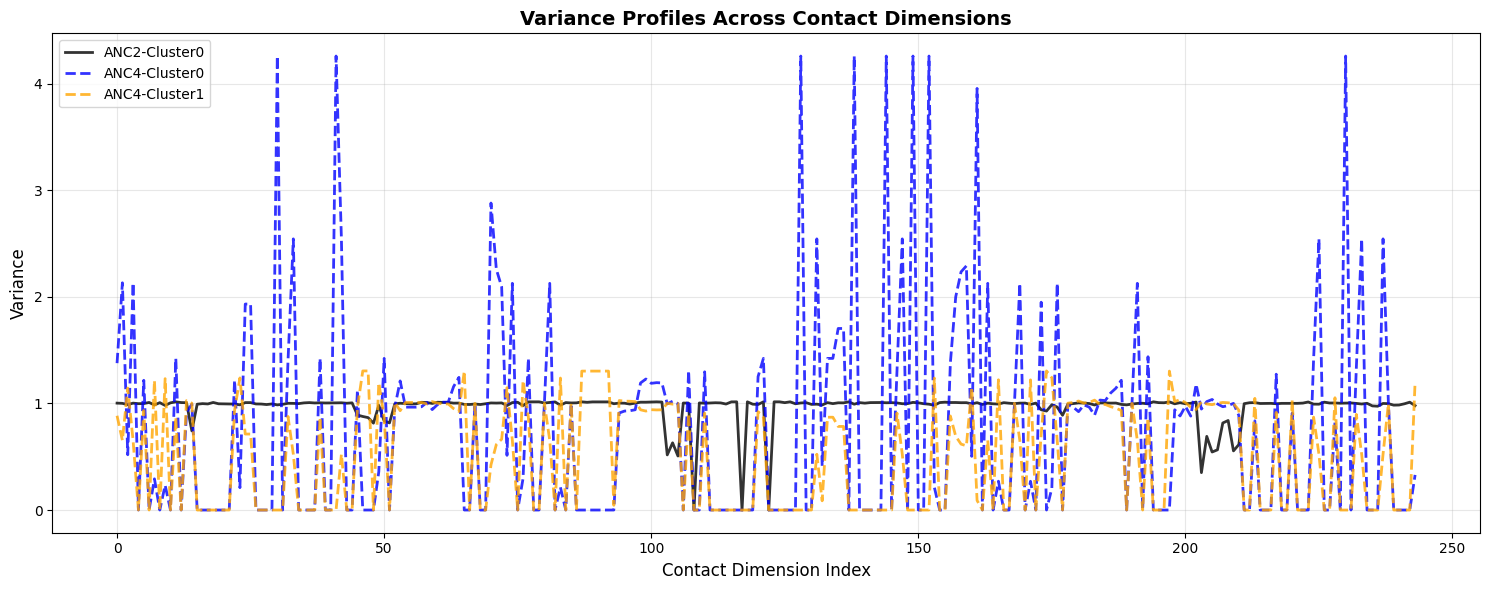

ANC2-Cluster0 方差范围: 0.000001 - 1.015226
ANC3-Cluster0 方差范围: 0.000001 - 4.259502
ANC3-Cluster1 方差范围: 0.000001 - 1.305085


In [44]:
def plot_variance_profiles(anc2_cov, anc3_cov, figsize=(15, 6)):
    """
    绘制多序列方差剖面线图
    
    Args:
        anc2_cov: ANC2的协方差矩阵 (2, 244, 244)
        anc3_cov: ANC3的协方差矩阵 (2, 244, 244)
        figsize: 图片大小
    """
    import matplotlib.pyplot as plt
    
    # 提取方差（对角线元素）
    anc2_cluster0_var = np.diag(anc2_cov[0])
    anc3_cluster0_var = np.diag(anc3_cov[0])
    anc3_cluster1_var = np.diag(anc3_cov[1])
    
    # X轴：接触维度索引
    x = np.arange(len(anc2_cluster0_var))
    
    # 创建图形
    plt.figure(figsize=figsize)
    
    # 绘制三条线
    plt.plot(x, anc2_cluster0_var, 'k-', linewidth=2, label='ANC2-Cluster0', alpha=0.8)
    plt.plot(x, anc3_cluster0_var, 'b--', linewidth=2, label='ANC4-Cluster0', alpha=0.8)
    plt.plot(x, anc3_cluster1_var, color='orange', linestyle='--', linewidth=2, label='ANC4-Cluster1', alpha=0.8)
    
    # 设置标签和标题
    plt.xlabel('Contact Dimension Index', fontsize=12)
    plt.ylabel('Variance', fontsize=12)
    plt.title('Variance Profiles Across Contact Dimensions', fontsize=14, fontweight='bold')
    
    # 添加图例和网格
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 调整布局
    plt.tight_layout()
    plt.show()
    
    # 打印一些统计信息
    print(f"ANC2-Cluster0 方差范围: {np.min(anc2_cluster0_var):.6f} - {np.max(anc2_cluster0_var):.6f}")
    print(f"ANC3-Cluster0 方差范围: {np.min(anc3_cluster0_var):.6f} - {np.max(anc3_cluster0_var):.6f}")
    print(f"ANC3-Cluster1 方差范围: {np.min(anc3_cluster1_var):.6f} - {np.max(anc3_cluster1_var):.6f}")

# 使用示例
plot_variance_profiles(anc2_cov, anc4_cov)

In [58]:
# 1. 计算Var_Anc3_c0与Var_Anc2_c0的比值，找出变化最大的10-15个接触
var_anc2_c0 = np.diag(anc2_cov[0])
var_anc3_c0 = np.diag(anc3_cov[0])

# # 计算比值（添加epsilon避免除零）
# epsilon = 1e-10
# ratio_anc3_anc2_c0 = (var_anc3_c0 + epsilon) / (var_anc2_c0 + epsilon)

# # 找出变化最大的15个（比值最大或最小）
# abs_log_ratio_anc3_anc2 = np.abs(np.log2(ratio_anc3_anc2_c0))
# top_15_indices_anc3_anc2 = np.argsort(abs_log_ratio_anc3_anc2)[-15:][::-1]

diff_anc3_anc2_c0 = var_anc3_c0 - var_anc2_c0
top_15_indices_anc3_anc2 =np.argsort(np.abs(diff_anc3_anc2_c0))[-15:][::-1] 

print("=== Var_Anc3_c0 vs Var_Anc2_c0 变化最大的15个接触 ===")
for i, idx in enumerate(top_15_indices_anc3_anc2):
    contact_info = get_contact_info(critical_contacts, idx, results['alternate_residue_types'])
    diff = diff_anc3_anc2_c0[idx]
    print(f"{i+1:2d}. Index {idx:3d}: {contact_info:15s} | Diff = {diff:.4f}")

print(f"top_15_indices_anc3_anc2: {top_15_indices_anc3_anc2}")

# 2. 计算Var_Anc4_c1与Var_Anc3_c1的比值（新对新）
var_anc3_c1 = np.diag(anc3_cov[1])
var_anc4_c1 = np.diag(anc4_cov[1])

# ratio_anc4_anc3_c1 = (var_anc4_c1 + epsilon) / (var_anc3_c1 + epsilon)
diff_anc4_anc3_c1 = var_anc4_c1 - var_anc3_c1
# abs_log_ratio_anc4_anc3_c1 = np.abs(np.log2(ratio_anc4_anc3_c1))
top_15_indices_anc4_anc3_c1 = np.argsort(np.abs(diff_anc4_anc3_c1))[-15:][::-1]

print("\n=== Var_Anc4_c1 vs Var_Anc3_c1 (新对新) 变化最大的15个接触 ===")
for i, idx in enumerate(top_15_indices_anc4_anc3_c1):
    contact_info = get_contact_info(critical_contacts, idx, results['alternate_residue_types'])
    diff = diff_anc4_anc3_c1[idx]
    print(f"{i+1:2d}. Index {idx:3d}: {contact_info:15s} | Diff = {diff:.4f}")

print(f"top_15_indices_anc4_anc3_c1: {top_15_indices_anc4_anc3_c1}")

# 3. 计算Var_Anc4_c0与Var_Anc3_c0的比值（旧对旧）
var_anc4_c0 = np.diag(anc4_cov[0])

# ratio_anc4_anc3_c0 = (var_anc4_c0 + epsilon) / (var_anc3_c0 + epsilon)
# abs_log_ratio_anc4_anc3_c0 = np.abs(np.log2(ratio_anc4_anc3_c0))
diff_anc4_anc3_c0 = var_anc4_c0 - var_anc3_c0
# top_15_indices_anc4_anc3_c0 = np.argsort(abs_log_ratio_anc4_anc3_c0)[-15:][::-1]
top_15_indices_anc4_anc3_c0 = np.argsort(np.abs(diff_anc4_anc3_c0))[-15:][::-1]

print("\n=== Var_Anc4_c0 vs Var_Anc3_c0 (旧对旧) 变化最大的15个接触 ===")
for i, idx in enumerate(top_15_indices_anc4_anc3_c0):
    contact_info = get_contact_info(critical_contacts, idx, results['alternate_residue_types'])
    diff = diff_anc4_anc3_c0[idx]
    print(f"{i+1:2d}. Index {idx:3d}: {contact_info:15s} | Diff = {diff:.4f}")

print(f"top_15_indices_anc4_anc3_c0: {top_15_indices_anc4_anc3_c0}")

# 如果你想要差值而不是比值，可以用这些：
# diff_anc3_anc2_c0 = var_anc3_c0 - var_anc2_c0
# diff_anc4_anc3_c1 = var_anc4_c1 - var_anc3_c1  
# diff_anc4_anc3_c0 = var_anc4_c0 - var_anc3_c0
# 然后用 np.argsort(np.abs(diff_xxx))[-15:][::-1] 找最大变化


=== Var_Anc3_c0 vs Var_Anc2_c0 变化最大的15个接触 ===
 1. Index 123: A49-W55         | Diff = -1.0152
 2. Index 116: F39-A49         | Diff = -1.0152
 3. Index 124: A49-V56         | Diff = -1.0152
 4. Index 137: K8-A49          | Diff = -1.0152
 5. Index  78: I24-A49         | Diff = -1.0152
 6. Index 118: F39-V59         | Diff = -1.0152
 7. Index  79: I24-V59         | Diff = -1.0152
 8. Index 126: A49-V59         | Diff = -1.0152
 9. Index 115: I38-A49         | Diff = -1.0147
10. Index 155: V12-A49         | Diff = -1.0120
11. Index  75: I24-G44         | Diff = -1.0108
12. Index 129: P51-R57         | Diff = -1.0074
13. Index 125: A49-R57         | Diff = -1.0074
14. Index 112: V37-R57         | Diff = -1.0065
15. Index 113: V37-V59         | Diff = -1.0050
top_15_indices_anc3_anc2: [123 116 124 137  78 118  79 126 115 155  75 129 125 112 113]

=== Var_Anc4_c1 vs Var_Anc3_c1 (新对新) 变化最大的15个接触 ===
 1. Index 155: V12-A49         | Diff = -6.9405
 2. Index 111: V37-V56         | Diff = -6.86

In [77]:
anc3_top_7_blue =[121  ,50,  77,  11 , 10, 167,  38]
anc3_top_15_red = [155,111,129,151,125,113,219,109,231,27,106,234,19,229,112]
anc4_top_15_red = [174,47,46,88,89,197,92,90,65,91,87,93,175,23,83]
anc4_top_8_blue = [144,30,128,230,41,149,138,152]
top_15_indices_anc3_anc2=[123,116,124,137,78,118,79,126,115,155,75,129,125,112,113]
top_15_indices_anc4_anc3_c1=[155,111,129,125,151,113,219,109,231,27,106,234,19,229,112]
top_15_indices_anc4_anc3_c0=[144,230,149,30,41,138,152,128,161,147,70,131,233,225,33]



# 直接统计版本
from collections import Counter

# 假设你的list变量名是这些，替换成你实际的变量名
all_lists = [
    anc3_top_7_blue,
    anc3_top_15_red,
    anc4_top_15_red,
    anc4_top_8_blue,
    top_15_indices_anc3_anc2,
    top_15_indices_anc4_anc3_c1, 
    top_15_indices_anc4_anc3_c0
]

# 合并所有元素并统计
all_elements = []
for lst in all_lists:
    all_elements.extend(lst)

counter = Counter(all_elements)

print("=== 元素出现次数统计 ===")
for element, count in counter.most_common():
    if count > 0:  # 只显示出现超过1次的
        print(f"Element {element}: {count} 次")
        # 如果是contact index，可以显示contact信息
        if 'critical_contacts' in globals():
            contact_info = get_contact_info(critical_contacts, element, results['alternate_residue_types'])
            print(f"  -> Contact: {contact_info}")


=== 元素出现次数统计 ===
Element 155: 3 次
  -> Contact: V12-A49
Element 129: 3 次
  -> Contact: P51-R57
Element 125: 3 次
  -> Contact: A49-R57
Element 113: 3 次
  -> Contact: V37-V59
Element 112: 3 次
  -> Contact: V37-R57
Element 111: 2 次
  -> Contact: V37-V56
Element 151: 2 次
  -> Contact: C11-V37
Element 219: 2 次
  -> Contact: G32-R57
Element 109: 2 次
  -> Contact: V37-P51
Element 231: 2 次
  -> Contact: L34-P51
Element 27: 2 次
  -> Contact: L14-V37
Element 106: 2 次
  -> Contact: L34-C48
Element 234: 2 次
  -> Contact: L34-V56
Element 19: 2 次
  -> Contact: C11-L34
Element 229: 2 次
  -> Contact: L34-A49
Element 144: 2 次
  -> Contact: R9-D50
Element 30: 2 次
  -> Contact: L14-D50
Element 128: 2 次
  -> Contact: D50-R57
Element 230: 2 次
  -> Contact: L34-D50
Element 41: 2 次
  -> Contact: T15-D50
Element 149: 2 次
  -> Contact: T10-D50
Element 138: 2 次
  -> Contact: K8-D50
Element 152: 2 次
  -> Contact: C11-D50
Element 121: 1 次
  -> Contact: T41-V47
Element 50: 1 次
  -> Contact: Q17-V47
Element 77: 1 次

In [67]:
def analyze_contact_evolution(contact_index, critical_contacts, results, 
                            anc2_cov, anc3_cov, anc4_cov, 
                            anc3_lollipop_stats, anc4_lollipop_stats):
    """
    分析单个contact在演化过程中的变化
    
    Args:
        contact_index: contact的索引
        其他参数: 各种数据和统计结果
    """
    import matplotlib.pyplot as plt
    
    # 1. 获取基本信息
    contact_info = get_contact_info(critical_contacts, contact_index, results['alternate_residue_types'])
    contact_pair = critical_contacts[contact_index]
    
    # 判断contact类型
    if contact_pair in results['lost_contacts']:
        contact_type = "LOST"
    elif contact_pair in results['new_contacts']:
        contact_type = "GAIN"
    else:
        contact_type = "UNKNOWN"
    
    # 2. 获取lollipop数值
    anc3_log_ratio = anc3_lollipop_stats['log_ratios'][contact_index]
    anc4_log_ratio = anc4_lollipop_stats['log_ratios'][contact_index]
    
    # 3. 提取各个cluster的方差
    anc2_c0_var = np.diag(anc2_cov[0])[contact_index]
    anc3_c0_var = np.diag(anc3_cov[0])[contact_index]
    anc3_c1_var = np.diag(anc3_cov[1])[contact_index]
    anc4_c0_var = np.diag(anc4_cov[0])[contact_index]
    anc4_c1_var = np.diag(anc4_cov[1])[contact_index]
    
    # 4. 打印信息
    print(f"=== Contact分析: Index {contact_index} ===")
    print(f"Contact信息: {contact_info}")
    print(f"Contact类型: {contact_type}")
    print(f"ANC3 Lollipop值: {anc3_log_ratio:.4f}")
    print(f"ANC4 Lollipop值: {anc4_log_ratio:.4f}")
    print(f"方差变化:")
    print(f"  ANC2-C0: {anc2_c0_var:.2e}")
    print(f"  ANC3-C0: {anc3_c0_var:.2e}")
    print(f"  ANC4-C0: {anc4_c0_var:.2e}")
    print(f"  ANC3-C1: {anc3_c1_var:.2e}")
    print(f"  ANC4-C1: {anc4_c1_var:.2e}")
    
    # 5. 绘图
    fig, ax = plt.subplots(figsize=(5, 3))
    
    # Cluster 0 演化线 (旧折叠)
    anc_names = ['ANC2', 'ANC3', 'ANC4']
    c0_variances = [anc2_c0_var, anc3_c0_var, anc4_c0_var]
    ax.plot(anc_names, c0_variances, 'o-', linewidth=2, markersize=8, 
            label='Cluster 0', color='blue')
    
    # Cluster 1 演化线 (新折叠，从ANC3开始)
    anc_names_c1 = ['ANC3', 'ANC4']
    c1_variances = [anc3_c1_var, anc4_c1_var]
    ax.plot(anc_names_c1, c1_variances, 'o-', linewidth=2, markersize=8, 
            label='Cluster 1', color='red')
    
    # 设置图形
    ax.set_xlabel('ancestor', fontsize=12)
    ax.set_ylabel('variance', fontsize=12)
    ax.set_title(f'Contact {contact_index} ({contact_info}) - {contact_type}\nvariance evolution', 
                fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 添加数值标注
    for i, (name, var) in enumerate(zip(anc_names, c0_variances)):
        ax.annotate(f'{var:.2e}', (i, var), textcoords="offset points", 
                   xytext=(0,10), ha='center', fontsize=9, color='blue')
    
    for i, (name, var) in enumerate(zip(anc_names_c1, c1_variances)):
        ax.annotate(f'{var:.2e}', (i+1, var), textcoords="offset points", 
                   xytext=(0,-15), ha='center', fontsize=9, color='red')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'contact_info': contact_info,
        'contact_type': contact_type,
        'anc3_lollipop': anc3_log_ratio,
        'anc4_lollipop': anc4_log_ratio,
        'variances': {
            'anc2_c0': anc2_c0_var,
            'anc3_c0': anc3_c0_var,
            'anc3_c1': anc3_c1_var,
            'anc4_c0': anc4_c0_var,
            'anc4_c1': anc4_c1_var
        }
    }


anc3_lollipop_stats = plot_variance_ratio_lollipop(anc3_cov, critical_contacts, results, visualize=False)
anc4_lollipop_stats = plot_variance_ratio_lollipop(anc4_cov, critical_contacts, results, visualize=False)
                           




=== 对数方差比统计 ===
最大值: 22.7265
最小值: -20.1555
平均值: 1.8932
标准差: 6.8644
Cluster0 > Cluster1 的数量: 147
Cluster0 < Cluster1 的数量: 76

=== 对数方差比统计 ===
最大值: 20.3156
最小值: -22.0221
平均值: 0.0904
标准差: 6.0232
Cluster0 > Cluster1 的数量: 64
Cluster0 < Cluster1 的数量: 79


=== Contact分析: Index 77 ===
Contact信息: I24-V47
Contact类型: LOST
ANC3 Lollipop值: -20.1555
ANC4 Lollipop值: -0.7084
方差变化:
  ANC2-C0: 1.01e+00
  ANC3-C0: 1.17e+00
  ANC4-C0: 1.42e+00
  ANC3-C1: 1.00e-06
  ANC4-C1: 8.71e-01


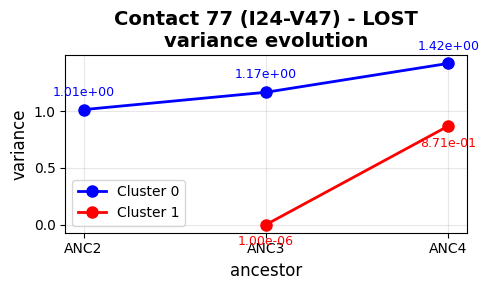

{'contact_info': 'I24-V47',
 'contact_type': 'LOST',
 'anc3_lollipop': np.float64(-20.155499873848967),
 'anc4_lollipop': np.float64(-0.7084283982951339),
 'variances': {'anc2_c0': np.float64(1.0149069263498451),
  'anc3_c0': np.float64(1.168028572992339),
  'anc3_c1': np.float64(1e-06),
  'anc4_c0': np.float64(1.4226828571476398),
  'anc4_c1': np.float64(0.8706626227643347)}}

In [76]:
analyze_contact_evolution(77, critical_contacts, results, anc2_cov, anc3_cov, anc4_cov,
                         anc3_lollipop_stats, anc4_lollipop_stats)

In [41]:
def analyze_top_variance_contacts(covariances, critical_contacts, results,sort='bottom', top_percent=0.1):
    """
    分析两个cluster各自方差top/bottom 10%的index以及对应的值和contact信息
    
    Args:
        covariances: 协方差矩阵 shape (2, 244, 244)
        critical_contacts: 关键接触点列表
        results: contact difference分析结果
        sort: 'top' or 'bottom'
        top_percent: 取top百分比，默认0.1 (10%)
    
    Returns:
        dict: 包含两个cluster的top variance分析结果
    """
    
    analysis_results = {}
    
    for cluster_id in range(2):
        print(f"\n=== Cluster {cluster_id} Top {int(top_percent*100)}% Variance Analysis ===")
        
        # 提取对角线元素（方差）
        variances = np.diag(covariances[cluster_id])
        
        # 计算top 10%的数量
        n_features = len(variances)
        top_n = int(n_features * top_percent)
        
        # 获取top variance的indices
        if sort == 'top':
            top_indices = np.argsort(variances)[-top_n:][::-1]  # 降序排列
        elif sort == 'bottom':
            top_indices = np.argsort(variances)[:top_n]  # 升序排列
        top_variances = variances[top_indices]
        
        print(f"Total features: {n_features}")
        print(f"Top {int(top_percent*100)}% count: {top_n}")
        print(f"Variance range: {top_variances[-1]:.6f} - {top_variances[0]:.6f}")
        
        # 获取contact信息
        contact_info_list = []
        for idx, variance in zip(top_indices, top_variances):
            contact_info = get_contact_info(critical_contacts, idx, results['alternate_residue_types'])
            contact_info_list.append({
                'index': idx,
                'variance': variance,
                'contact_info': contact_info
            })
            print(f"Index {idx:3d}: Variance = {variance:.6f}, Contact = {contact_info}")
        
        analysis_results[f'cluster_{cluster_id}'] = {
            'top_indices': top_indices,
            'top_variances': top_variances,
            'contact_info_list': contact_info_list,
            'total_features': n_features,
            'top_count': top_n
        }
    
    return analysis_results

# 使用你的数据进行分析
variance_analysis = analyze_top_variance_contacts(
    anc3_cov, 
    critical_contacts, 
    results, 
    sort='bottom',
    top_percent=0.1
)

# 可选：保存结果到变量以便后续使用
cluster0_top_indices = variance_analysis['cluster_0']['top_indices']
cluster0_top_variances = variance_analysis['cluster_0']['top_variances']
cluster0_contact_info = variance_analysis['cluster_0']['contact_info_list']

cluster1_top_indices = variance_analysis['cluster_1']['top_indices']
cluster1_top_variances = variance_analysis['cluster_1']['top_variances']
cluster1_contact_info = variance_analysis['cluster_1']['contact_info_list']

print(f"\n=== Summary ===")
print(f"Cluster 0 - Top variance range: {cluster0_top_variances[-1]:.6f} to {cluster0_top_variances[0]:.6f}")
print(f"Cluster 1 - Top variance range: {cluster1_top_variances[-1]:.6f} to {cluster1_top_variances[0]:.6f}")


=== Cluster 0 Top 10% Variance Analysis ===
Total features: 244
Top 10% count: 24
Variance range: 0.000001 - 0.000001
Index  27: Variance = 0.000001, Contact = L14-V37
Index  21: Variance = 0.000001, Contact = C11-I38
Index  20: Variance = 0.000001, Contact = C11-A36
Index  19: Variance = 0.000001, Contact = C11-L34
Index  48: Variance = 0.000001, Contact = Q17-F39
Index  51: Variance = 0.000001, Contact = Q17-A49
Index  34: Variance = 0.000001, Contact = L14-V56
Index 126: Variance = 0.000001, Contact = A49-V59
Index 123: Variance = 0.000001, Contact = A49-W55
Index 122: Variance = 0.000001, Contact = C48-V56
Index 117: Variance = 0.000001, Contact = F39-V56
Index 118: Variance = 0.000001, Contact = F39-V59
Index 113: Variance = 0.000001, Contact = V37-V59
Index  75: Variance = 0.000001, Contact = I24-G44
Index 112: Variance = 0.000001, Contact = V37-R57
Index 115: Variance = 0.000001, Contact = I38-A49
Index 108: Variance = 0.000001, Contact = A36-V56
Index 109: Variance = 0.000001,